In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# For the model
import normflows as nf

# For VIB Bayesian
from bayesian_torch.layers.flipout_layers.linear_flipout import LinearFlipout
from bayesian_torch.models.dnn_to_bnn import get_kl_loss

# For MCMC Bayesian
from MCMC_Adam import MCMC_by_bp

from sklearn.datasets import make_moons
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# How to Baysianify most NN

## Bayesian NN basics

In this notebool we will explore two options to promote a classical Neural Network (NN) $$\hat{y} = f_\theta (x)$$ to a Bayesian Neural Network (BNN), fastly and efficiently. Here $\theta$ are the parameters of the NN. 
Lets assume a matched training set $\mathcal{D} = \{(x_1,y_1), ..., (x_N, y_N)\}$ for supervised tasks, as well as a set $\mathcal{D}` = \{x_1`, ..., x_N`\}$. Here the dimension of the members of the set can be of arbitrary dimension.

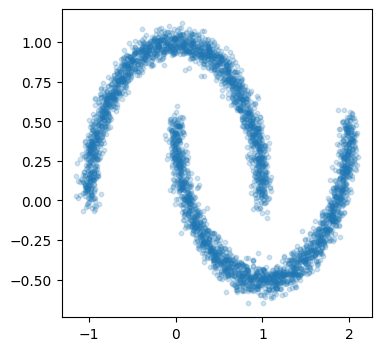

In [2]:
############
### data ###
############

data, _ = make_moons(4096, noise=0.05)
data = torch.from_numpy(data).float()

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(data[:, 0], data[:, 1], s=10, alpha=0.2)

We demonstrate the transition from classical to Bayesian NN with a simple regression example:

The deterministic model has 5934


100%|██████████| 5000/5000 [01:05<00:00, 76.67it/s]
/tmp/ipykernel_5819/942508098.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5819/942508098.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


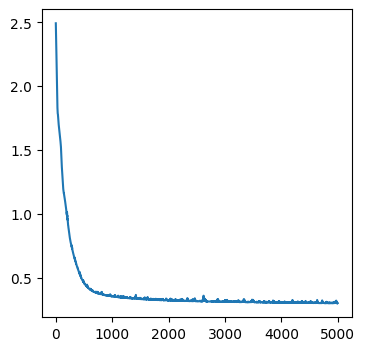

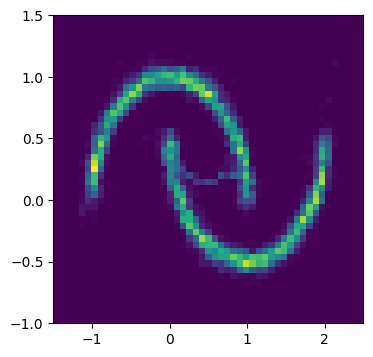

In [3]:
####################
### classical NF ###
####################

epochs = 5000
batchsize = len(data)
lr = 1e-3

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 5
flows = []
for i in range(num_layers):
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 32, 32, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))

model = nf.NormalizingFlow(base, flows).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(f"The deterministic model has {sum(p.numel() for p in model.parameters())} parameters")

model.train()

data = data.to(device)
flow_loss_epoch = np.zeros(epochs)

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()

    perm = torch.randperm(len(data)).to(device)
    for i_step in range((len(data)-1)//batchsize+1):
        x = data[perm[i_step*batchsize:(i_step+1)*batchsize].to(device)]

        flow_loss = -torch.mean(model.log_prob(x))

        flow_loss.backward()
        optimizer.step()

        flow_loss_epoch[epoch] += flow_loss.numpy(force=True)

torch.save(model.state_dict(), f"./models/det_model_{epoch}.pth")

model.eval()

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(flow_loss_epoch)
fig.show()

x_gen,_ = model.sample(10000)
x_gen= x_gen.numpy(force=True)
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist2d(x_gen[:, 0], x_gen[:, 1], bins =(np.linspace(-1.5,2.5,50), np.linspace(-1,1.5,50)))
fig.show()

### Aleatoric uncertainty

It is necessary to start out with a NN trained on a $\log$-likelihood loss. This implies probabilistic network predictions 
$$\hat y = \langle y \rangle_{y \sim p_\theta(\cdot | x_i)} = \langle y \rangle_{y \sim f_\theta(x_i)},$$ 
rather than single point predictions. The prediction can come in different forms for different tasks:
* Classification: Using e.g. a softmax output layer, classififaction output is often used a "probability per class" which is nothing else but the probability distribution in a discretized output. The (Binary) Cross-Entropy loss often encountered, then is the $\log$-likelihood of the discrete distribution.
* Regression: For regression, one can predict $\mu$ and $\sigma$ of a Normal distribution $p_\theta(\cdot | x_i) = \mathcal{N}(\cdot|\mu = f_{\theta,1}(x_i), \sigma = f_{\theta,2}(x_i))$. For the special case of constant $f_{\theta,2}(x_i) = 1$, the $\log$-likelihood of this Normal distribution equals the well known MSE.
* Generative ML: Many generative architecture as (continouos) Normalizing Flows and diffusion models already employ $\log$-likelihood losses. In this context, conditional generative NNs can be understood as a more flexible parametrization for a regression fit.

Importantly, this $\log$-likelihood is minimized to achieve best agreement between the estimated distribution $p(\cdot | x_i)$. 
It thus fits the noise distribution of the data and the uncertainty $$\sigma_\mathrm{alea}^2 = \langle y^2 \rangle_{y \sim p_\theta(\cdot | x_i)} - \langle y \rangle_{y \sim p_\theta(\cdot | x_i)}^2$$ based in it describes the noise of the data. 
Of course, you can choose a different, better fitting metric to descibe the noise, e.g. the min-max envelope or quantiles.
In Machine Learning (ML) we call this uncertainty **aleatoric**, wheres in HEP it is often referred to as **systematic**, and distinguish to different types of uncertainty here:
* homoskedastic uncertainty: The uncertainty is independent of the network input and only depents on the overall Dataset. For regression this mean $f_{\theta,2}(x_i) = \text{constant}$.
* heteroskedastic uncertainty: The shape (width) of the predicted distribution depends on the specific input. 

In the following, I will always use heteroskedastic uncertainty, as I do not see any upsides (other than having a simpler model) to constant uncertainties.

### Epistemic uncertainty

Having access to the $\log$-likelihood of the data $\mathcal{D}$ 
$$\pi(\mathcal{D}|\theta) = \sum_{i=1}^N p_\theta(y_i | x_i)$$ 
allows us access to use Bayes formula to access the posterior distribition 
$$\pi(\theta|\mathcal{D}) = \frac{\pi(\mathcal{D}|\theta) \pi(\theta)}{\pi(\mathcal{D})}.$$
This also introduces a third distribtuion, the **prior** distribution $\pi(\theta).$
In Bayesian statistics, it encodes our believes on the network parameters before applying the model to data. The integrated likelihood $\pi(\mathcal{D})$ is constant w.r.t. the network paramaters and thus is of no interest to us.

Knowing the posterior distribution allows us to promote the frequentist, single prediction $\hat y = \langle y \rangle_{p_\theta(\cdot | x_i)}$ into a Bayesian setting, by calculating the mean and standard devetion (or min-max envelope or ...) of the prediction over the posterior
$$ \hat{\bar{y}}  =  \langle \hat y \rangle_{\theta \sim \pi(\cdot|\mathcal{D})} = \langle y \rangle_{y \sim p_\theta(\cdot | x_i), \theta \sim \pi(\cdot|\mathcal{D})},$$
$$\sigma_\mathrm{epis}^2 = \langle \hat y^2 \rangle_{\theta \sim \pi(\cdot|\mathcal{D})} - \langle \hat y \rangle_{\theta \sim \pi(\cdot|\mathcal{D})}^2.$$
This so-called **epistemic uncertainty** (in physics often **statistic uncerttainty**) depends on the quality of the $\log$-likelihood fit, a bad fit e.g. due to sparse data, will lead to multiple NN parameter settings with similar $\log$-likelihood values and thus to a wide posterior distribution. 
In a more Bayesian sense, one could also phrase: A bad fit leads to a wide $\log$-likelihood (in $\theta$) and thus the prior $\pi(\theta)$ dominates Bayes formula. 
We will end up with a high-error estimate close to our prior distribution.
The choice of the prior distribution is thus crucial to adapt the behavior of the prediction for low (or none) statistics.

There is multiple ways to access the posterior distribution, that I will give a hands-on introduction to in the following section.

## Accessing the Posterior

Note: ML research has shown that it is often sufficient to only treat the last layer(s) of a NN as Bayesian for a reliable epistemic error estimate at a lower cost.

### Approximating the Posterior 

There are multiple a appoximations for NN posteriors, such as the Laplace approximation (Normal distribution from mean and second derivative of the $\log$-likelihood) and Gaussian Processes. 
However, I will only address the most widespread flavour here.
It is often referred to as **Bayes-by-Backpropagation** or **Variational Inference Bayes**. 
In HEP it is often simply called a "Bayesian NN".
To avoid confusion I will refer to it as Variational Inference Bayes (VIB).

The idea is simple: We assume the posterior distribution $\pi(\theta|\mathcal{D})$ to be well approximated by an uncorrelated Gaussian $q(\theta)$ distribution. 
Because all dimensions are uncorrelated, the covariance-matrix of the multidimensional Gaussian is diagonal and we can simply use a mean and standard deviation per weight.
$$ \theta_p \sim \mathcal{N}(\mu_p, \sigma_p) \text{ for } p \in \{1,...,P\},$$
where $P$ is the number of network weights.

For most common layer architectures, VIB-phrasings are provided e.g by BayesianTorch (https://github.com/IntelLabs/bayesian-torch) or Blitz-Bayesian (https://pypi.org/project/blitz-bayesian-pytorch/). The BayesianTorch package also provides a feature to promote classical NN to BNNs, which we will not use here for a more instructive notebook.


In [10]:
class LinearFlipout_MLP(nn.Module):
    """
    Equivalent to the nf.MLP (multilayer perceptron with Leaky ReLU nonlinearities),
    but with LinearFlipout layers
    """

    def __init__(
        self,
        layers,
        leaky=0.0,
        score_scale=None,
        output_fn=None,
        output_scale=None,
        dropout=None,
        prior_variance=1.
    ):
        """
        layers: list of layer sizes from start to end
        leaky: slope of the leaky part of the ReLU, if 0.0, standard ReLU is used
        score_scale: Factor to apply to the scores, i.e. output before output_fn.
        output_fn: String, function to be applied to the output, either None, "sigmoid", "relu", "tanh", or "clampexp"
        output_scale: Rescale outputs if output_fn is specified, i.e. ```scale * output_fn(out / scale)```
        dropout: Float, if specified, dropout is done before last layer; if None, no dropout is done
        prior_variance: Float, variance of the Bayesian Layers
        """
        super().__init__()
        net = nn.ModuleList([])
        for k in range(len(layers) - 2):
            net.append(LinearFlipout(layers[k], layers[k + 1], prior_variance=prior_variance)) #change the original nn.Linear to LinearFlipout here
            net.append(nn.LeakyReLU(leaky))
        if dropout is not None:
            net.append(nn.Dropout(p=dropout))
        net.append(LinearFlipout(layers[-2], layers[-1], prior_variance=prior_variance))

        if output_fn is not None:
            if score_scale is not None:
                net.append(utils.ConstScaleLayer(score_scale))
            if output_fn == "sigmoid":
                net.append(nn.Sigmoid())
            elif output_fn == "relu":
                net.append(nn.ReLU())
            elif output_fn == "tanh":
                net.append(nn.Tanh())
            elif output_fn == "clampexp":
                net.append(utils.ClampExp())
            else:
                NotImplementedError("This output function is not implemented.")
            if output_scale is not None:
                net.append(utils.ConstScaleLayer(output_scale))
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

In [11]:
###########################
### VIB-NF architecture ###
###########################

epochs = 10000 
batchsize = len(data)
lr = 1e-3
pv = 1
n_sample = 1

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 5
flows = []
for i in range(num_layers):
    # Use Bayesian layer instead of classical - I like the flipout architecture for better stability
    param_map = LinearFlipout_MLP([1, 32, 32, 2], prior_variance=pv) #torch.nn.Sequential(LinearFlipout(1, 32, prior_variance=pv), LinearFlipout(32, 32, prior_variance=pv), LinearFlipout(32, 2, prior_variance=pv))
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))

model_VIB = nf.NormalizingFlow(base, flows).to(device)
print(f"The VIB model has {sum(p.numel() for p in model_VIB.parameters())} parameters")

for layer in model_VIB.modules():
    if isinstance(layer, LinearFlipout):
        layer._dnn_to_bnn_flag = True #flag for running training

optimizer = torch.optim.Adam(model_VIB.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 1)

# Sadly the training is hard to get to converge so we set the priors from the result of the classical optimization (MOPED)
#model_VIB = MOPED(model_VIB.flows, model.flows, pv)

The VIB model has 11864 parameters


When optimizing the resulting architecture, one minimizes the Kullback-Leibler (KL) divergence of posterior and approximation. 
Using Bayes formula, it can be recasted as:
$$\mathrm{KL} (q(\theta)|\pi(\theta|\mathcal{D})) = \int q(\theta) \log\frac{q(\theta)}{\pi(\theta|\mathcal{D})} d\theta = \int q(\theta) \log\frac{q(\theta)\pi{\mathcal{D}}}{\pi(\mathcal{D}|\theta)\pi{\theta}} d\theta = \int q(\theta) \left( -\log\pi(\mathcal{D}|\theta) +\log \frac{q(\theta)}{\pi{\theta}} + \text{const.} \right) d\theta = - \langle \log\pi(\mathcal{D}|\theta)\rangle_{q(\theta)} + \mathrm{KL} (q(\theta)|\pi(\theta)) + \text{const.} $$
We can thus use the $\log$-likelihood of our network and need to only add the KL divergence to the prior. 
The KL divergence to the prior is easy to calculate when assuming both Gaussian priors and a Gaussian approximation.
Most packages for Baysian NN already cater the KL divergence when applying the layer, so we only need to sum over all layers.

In [12]:
############################
### VIB-NF loss and loop ###
############################

model_VIB.train()

data = data.to(device)
flow_loss_epoch, bayesian_kl_to_prior_loss_epoch = np.zeros(epochs), np.zeros(epochs)

eps = tqdm(range(epochs))
for epoch in eps:
    optimizer.zero_grad()

    perm = torch.randperm(len(data)).to(device)
    for i_step in range((len(data)-1)//batchsize+1):
        x = data[perm[i_step*batchsize:(i_step+1)*batchsize].to(device)]

        # take the average over multiple instances from \langle \log\pi(\mathcal{D}|\theta)\rangle_{q(\theta)} for sampling the mean (1 often is sufficient)
        flow_loss = -torch.mean(model_VIB.log_prob(x))
        for i in range(n_sample-1):
            # take the sum over all log_probs to get the log prob of the full set --> divide by len(x) in kl_loss to get same scaling
            flow_loss += -torch.mean(model_VIB.log_prob(x))
        flow_loss /= n_sample

        bayesian_kl_to_prior_loss = get_kl_loss(model_VIB)/len(x)

        loss_total = flow_loss + bayesian_kl_to_prior_loss

        if ~(torch.isnan(loss_total) | torch.isinf(loss_total)):
            loss_total.backward()
            optimizer.step()
            #scheduler.step()

        flow_loss_epoch[epoch] += flow_loss.numpy(force=True)
        bayesian_kl_to_prior_loss_epoch[epoch] += bayesian_kl_to_prior_loss.numpy(force=True)

        eps.set_postfix({'flow_loss': flow_loss.item(), 'bayesian_kl_to_prior_loss': bayesian_kl_to_prior_loss.item(), 'lr': scheduler.get_lr()[0]})

torch.save(model_VIB.state_dict(), f"./models/VIB_model_{epoch}.pth")

100%|██████████| 10000/10000 [08:03<00:00, 20.69it/s, flow_loss=0.3, bayesian_kl_to_prior_loss=0.0275, lr=0.001] 


/tmp/ipykernel_5819/1130519632.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5819/1130519632.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


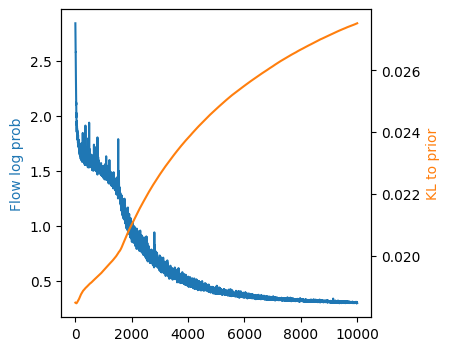

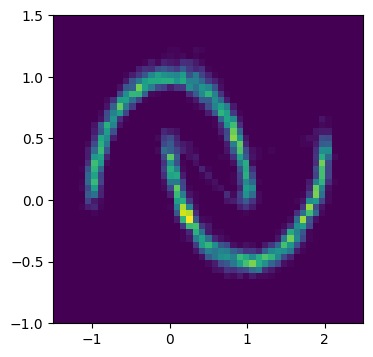

In [13]:
model.eval()

# train this until KL to prior term also converges!!
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(flow_loss_epoch, label = 'Flow log prob', color="C0")
ax.set_ylabel('Flow log prob', color = 'C0')
ax2 = ax.twinx() 
ax2.plot(bayesian_kl_to_prior_loss_epoch, label = 'KL to prior', color="C1")
ax2.set_ylabel('KL to prior', color = 'C1')
fig.show()

#the LinearFlipout Layer sampler weight values when it is called, for batched generation from the same weight drawing you should employ e.g. the wrapped LinearFlipout layer from the Classifier Surrogate code
x_gen,_ = model_VIB.sample(10000) 
x_gen= x_gen.numpy(force=True)
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist2d(x_gen[:, 0], x_gen[:, 1], bins =(np.linspace(-1.5,2.5,50), np.linspace(-1,1.5,50)))
fig.show()

The assumption of uncorrelated dimensions of the posterior distriution and a uni-modal shape is often suboptimal. Especially for out-of-distribution errors (i.e. errors where the training data does not reach), this often leads to underestimated uncertainties. A more flexible tool for inferring NN posterior distributions is Markov Chain Monte Carlo (MCMC).

### Sampling the Posterior

The idea of using MCMC to sample from NN posteriors is as old as the idea of NN itself. 
However, classical MCMC algorithms often suffer from poor convergence rates due to the high dimensionality of the network weights.
Furthermore, they require the evaluation of the $\log$-likelihood on the whole dataset. 
This is unfeacable for current applicaitons of NNs.

Common methods thus employ stochastic approximations (batches) and gradient descent to guide the chain. 
Popular chains are stochastic gradient Langevin Dynamics and (stochastic) Hamiltonian Monte Carlo.
Implemenations often assume either Regression or Classification settings and give little freedom to change the calculation of the $\log$-likelihood.
One of the best implementations I found is HamilTorch (https://github.com/AdamCobb/hamiltorch/).

However, I found it easiest to promote a NN training to MCMC sampling by simply adapting the optimizer step to include both calculation of a proposal for the next step in the chain and Metropolis-Hastings correction.
This is the way I wrote the **AdamMCMC** code.

**A short explanation on AdamMCMC:**

AdamMCMC is competing approach to MCMC sampling NN weights, that leverages Adam-optimization steps on the $\log$-likelihood loss $\mathcal{L}_{\mathrm{NLL}} (\theta_i) = \pi(\mathcal{D}|\theta_i)$ as a center for the proposal of a next step
$$\tilde\theta_{i+1} = \text{Adam}(\theta_i,  \mathcal{L}_{\mathrm{NLL}}(\theta_i)).$$
In combination with a proposal distribution that is elongated in the direction of the step
$$\tau_i \sim q(\cdot|\theta_i) = \mathcal{N}(\tilde\theta_{i+1},\sigma^2\mathrm{1}+\sigma_\Delta^2(\tilde\theta_{i+1} - \theta_i)(\tilde\theta_{i+1} - \theta_i)^\top)$$
this algorithm handles high dimensional sampling for neural networks very efficiently and results in a high acceptance rate in a consequent stochastic Metropolis-Hastings (MH) correction with acceptance probability
\begin{equation}
    \alpha = \frac{\exp \left(-\lambda \mathcal{L}_{\mathrm{NLL}}(\tau_i)\right) q(\theta_i | \tau_i)}{\exp \left(-\lambda \mathcal{L}_{\mathrm{NLL}}(\theta_i)\right) q(\tau_i | \theta_i)}.
\end{equation}
Both the inverse temperature parameter $\lambda$ and the noise parameter $\sigma$ tune the predicted uncertainties.
In theory small $\lambda$ and high $\sigma$ will result in high error estimates, albeit in practice the dependence on the inverse temperatures is often very weak, so I recommend setting $\lambda = 1$.

The noise in Adam direction $\sigma_\Delta$ hinders convergence if choosen to big, but allows efficient sampling at low values of $\sigma$. I have found a good working interval is  $\sigma_\Delta \in [P,\frac{P}{100}]$. 

When set correctly, AdamMCMC can handle high Adam-learning rates of up to $10^{-2}$. However, the higher the learning rate the smaller the area of good wroking hyperparameters. Therefore, it often makes sense to start the AdamMCMC-chain from a pretrained model at lower learning rates for a post-hoc uncertainty estimate.

In [30]:
###################
### AdamMCMC NF ###
###################

epochs = 10001
load_pretrained_epoch = None # you can start out from a classically optimized network here
batchsize = len(data)
lr = 1e-3

# Parameters need some more optimizing, but in principle everythin is running

temp = 1 #lambda: Higher parameter makes the Gibss-posterior sharper and the uncertainty smaller in theory. In practise there seldomly is a effect
sigma = .02 #noise: more noise means higher uncertainties, less noise can lead to overfitting. Very little or very high noise will crash the acceptance rate
loop_kwargs = {
            'MH': True, #use a MH correction! This is a little more than x2 runtime but necessary
            'verbose': epochs<10,
            'fixed_batches': True, #set this so the loss is calculated 2 times per step, for batchsize = len(data), this can be set to False to reduce calculation cost bei 50%
            'sigma_adam_dir': 800, #choose on the order of the number of parameters of the network
            'extended_doc_dict': False,
            'full_loss': None, #here a second loss function over the full data set can be passed to allow exact MH-corrections
}

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 5
flows = []
for i in range(num_layers):
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 32, 32, 2], init_zeros=False)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))

MCMC_model = nf.NormalizingFlow(base, flows).to(device)
MCMC_model.device = device
optimizer = torch.optim.Adam(MCMC_model.parameters(), lr=lr, betas=(0.999, 0.999))
adamMCMC = MCMC_by_bp(MCMC_model, optimizer, temp, sigma)

data = data.to(device)
flow_loss_epoch, acc_prob_epoch, accepted_epoch = np.zeros(epochs), np.zeros(epochs),  np.zeros(epochs)

#load the pretrained model
if load_pretrained_epoch is not None:
    MCMC_model.load_state_dict(torch.load(f"./models/det_model_{load_pretrained_epoch}.pth"))

eps = tqdm(range(epochs))
for epoch in eps:    
    optimizer.zero_grad()

    perm = torch.randperm(len(data)).to(device)
    for i_step in range((len(data)-1)//batchsize+1):
        x = data[perm[i_step*batchsize:(i_step+1)*batchsize].to(device)]

        # Need to definde the 
        flow_loss = lambda: -torch.sum(MCMC_model.log_prob(x)) #use the sum over the full batch here or use adamMCMC.n_points = len(data) to rescale to the loss within the sampler
        flow_loss_old,accept_prob,accepted,_,_ = adamMCMC.step(flow_loss, **loop_kwargs)

        flow_loss_epoch[epoch] += flow_loss_old.numpy(force=True)/len(x)
        acc_prob_epoch[epoch] = accept_prob
        accepted_epoch[epoch] = accepted

        #save the ensemble after some burn-in time (to converge) in sufficiently large intervals
        #if you loaded a pretrained model, you can also reduce/skip the burn-in
        if epoch>4999 and epoch%1000==0:
            torch.save(MCMC_model.state_dict(), f"./models/MCMC_model_{epoch}.pth")

        eps.set_postfix({'flow_loss': flow_loss_old.item()/len(x), 'accept_prob': accept_prob})

  0%|          | 0/10001 [00:00<?, ?it/s, flow_loss=2.65, accept_prob=tensor(0., device='cuda:0')]

100%|██████████| 10001/10001 [08:35<00:00, 19.41it/s, flow_loss=0.36, accept_prob=tensor(0.0014, device='cuda:0')]     


/tmp/ipykernel_7222/2077049462.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_7222/2077049462.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_7222/2077049462.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


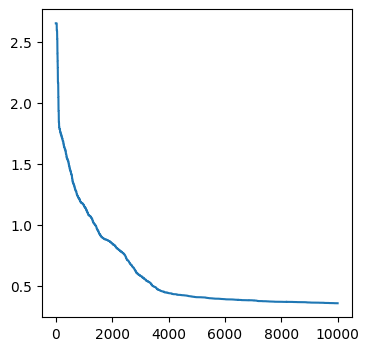

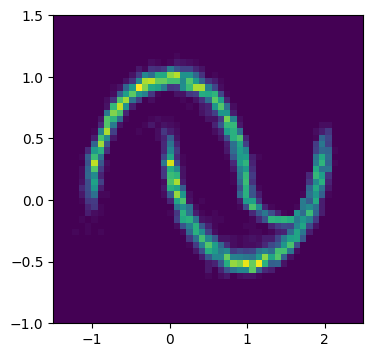

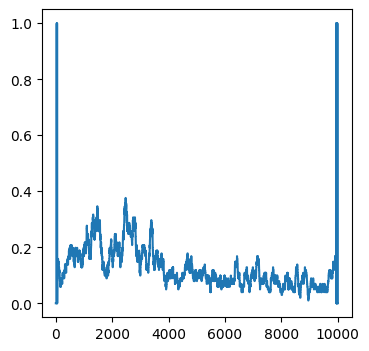

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(flow_loss_epoch)
fig.show()

x_gen,_ = MCMC_model.sample(10000)
x_gen= x_gen.numpy(force=True)
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist2d(x_gen[:, 0], x_gen[:, 1], bins =(np.linspace(-1.5,2.5,50), np.linspace(-1,1.5,50)))
fig.show()

def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(smooth(accepted_epoch,101))
fig.show()